# Keyboard SMASH

> Smash: text generated by "randomly" smashing your fingers into the keyboard

## Helper functions

In [156]:
from collections import Counter
from dataclasses import dataclass
import glob
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy import spatial
from sklearn.decomposition import PCA

In [141]:
def get_smashes(path):
    with open(path) as fi:
        lines = [line.strip() for line in fi.readlines()]
        return lines

def to_monostring(smashes):
    return "".join(smashes)

def get_name(path):
    return re.search('/([^\.]+)', path).group(1)

def to_normvector(monostring, alphabet):
    counts = Counter(monostring)
    vector = np.array([counts[c] for c in alphabet])
    normvector = vector/vector.sum()    
    return normvector 

def get_spatial_index(normvectors):
    return spatial.KDTree(normvectors)

def frag(names, smashes):
    for i, name in enumerate(names):
        for smash in smashes[i]:
            yield name, smash

@dataclass
class Entry:
    name: str
    path: str
    smashes: List[str]
    monostring: str

## Process data

In [184]:
# gather data
database = [
    Entry(name=get_name(path), path=path, monostring=to_monostring(smashes), smashes=smashes) 
    for path, smashes
    in [(path, get_smashes(path)) for path in glob.glob('smashes/*.txt')]
]
names, paths, monostrings, smashes = zip(*[(e.name, e.path, e.monostring, e.smashes) for e in database])
single_names, single_smashes = zip(*[(name, smash) for name, smash in frag(names, smashes)])



# Create alphabet
superstring = "".join([ms for ms in monostrings])
alphabet = sorted(list(set(list(superstring))))
print('Alphabet:', " ".join(alphabet[:25] + ['...']))

# Normalise monostrings and smashes
super_normvector = to_normvector(superstring, alphabet)
monostring_normvectors = [to_normvector(ms, alphabet) for ms in monostrings]
smashes_normvectors = [to_normvector(smash, alphabet) for smash in single_smashes]

# Spatial indexing
monostring_tree = get_spatial_index(monostring_normvectors)
smash_tree = get_spatial_index(smashes_normvectors)

Alphabet:   $ ' + , - . 0 2 3 4 5 6 7 8 9 < A L a b c d e f ...


## How are characters distributed in smashes?

How are characters distributed in smashes? What characters occur most and least frequently in keyboard smashes?

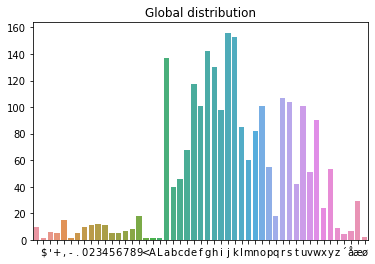

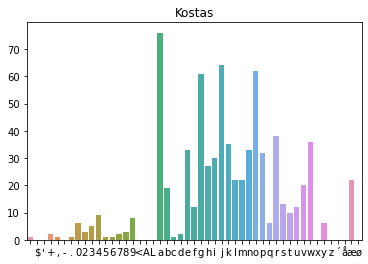

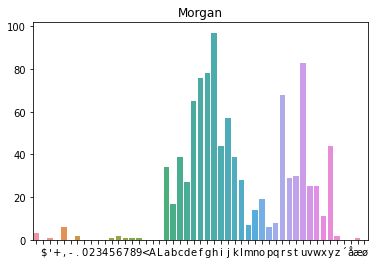

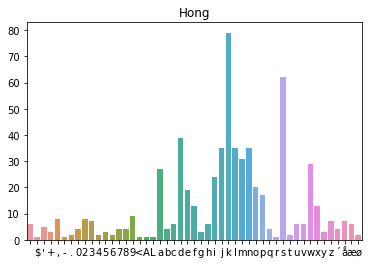

In [181]:
# global distribution
counts = Counter(allstring)
sns.barplot(x=alphabet, y=[counts[c] for c in alphabet])
plt.title('Global distribution')
plt.show()

# individual distributions
for name, monostring in zip(names, monostrings):
    counts = Counter(monostring)
    sns.barplot(x=alphabet, y=[counts[c] for c in alphabet])
    plt.title(name.title())
    plt.show()

## Do people smash differently??

Are smashes sufficiently different that you can you tell who performed a smash? It seems so.

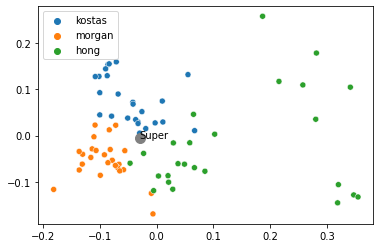

In [178]:
pca = PCA(n_components=2)
pca.fit(smashes_normvectors)
transformed_smashes = pca.transform(smashes_normvectors)
sns.scatterplot(x=transformed_smashes[:,0], y=transformed_smashes[:,1], hue=single_names)
transformed_super = pca.transform([super_normvector]) 
plt.scatter(transformed_super[0][0], transformed_super[0][1], marker='o', color='gray', s=100)
plt.annotate("Super", (transformed_super[0][0], transformed_super[0][1]), color='k')
plt.show()

## Who is the most normal smasher?

In [155]:
dist, idx = monostring_tree.query(super_normvector)
name = names[idx]
print('The most NORMAL keyboard smasher is:', name.title())

The most NORMAL keyboard smasher is: Kostas


## What was the most normal smash?

In [191]:
dist, idx = smash_tree.query(super_normvector)
print('The most NORMAL keyboard smash was:', single_smashes[idx])
print('The smasher was:', single_names[idx].title())


The most NORMAL keyboard smash was: fe,.hjtyujysjgbhilrespoijghfuohptrouxhilvj gkfdsui
The smasher was: Morgan
